# Distance between origins and destinations

Sam Maurer

This notebook uses OSMNx and NetworkX to calculate the shortest path between each origin and each destination in a list, and then pare down the combinations to highlight the closest.  
https://github.com/gboeing/osmnx-examples/tree/master/notebooks  
https://networkx.github.io/documentation/stable/reference/algorithms/shortest_paths.html

Pandana is another library to look into, but it's optimized for *counting destinations within a certain distance buffer* rather than finding shortest paths per se, so it may not be very helpful.  
http://udst.github.io/pandana/tutorial.html

## 1. Set up a street network graph and some origins and destinations

In [1]:
%%capture
!pip install osmnx

In [1]:
import numpy as np
import pandas as pd
import osmnx

### a. Get a street network

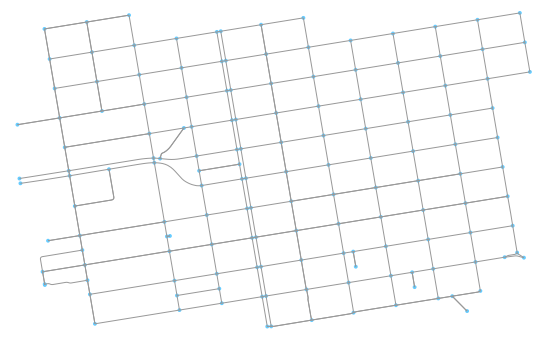

/Users/aarongatdula/.conda/envs/maps/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


In [2]:
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G = osmnx.graph_from_bbox(north, south, east, west, network_type='drive')

fig, ax = osmnx.plot_graph(osmnx.project_graph(G))
fig.show()

https://networkx.github.io/documentation/networkx-1.10/reference/classes.multidigraph.html

You can do things like `list(G.nodes)` or `list(G.edges)` to see what the data looks like, or  
`gdf_nodes, gdf_edges = osmnx.graph_to_gdfs(G)`.

### b. Get some origin and destination points

In [3]:
def random_point(north, south, east, west):
    """
    Generate a random point within a bounding box.
    
    """
    x = (east - west) * np.random.random() + west
    y = (north - south) * np.random.random() + south
    return (x, y)

In [6]:
# Generate some origins, randomly distributed across the neighborhood

x_list = []
y_list = []

for i in range(4):
    x, y = random_point(37.79, 37.78, -122.41, -122.43)
    x_list.append(x)
    y_list.append(y)

orig_df = pd.DataFrame({'x': x_list, 'y': y_list})
orig_df

x          y
0 -122.415707  37.787808
1 -122.415176  37.783918
2 -122.413391  37.787670
3 -122.415428  37.782392

In [7]:
# Generate some destinations, all in the western half

x_list = []
y_list = []

for i in range(4):
    x, y = random_point(37.79, 37.78, -122.42, -122.43)
    x_list.append(x)
    y_list.append(y)

dest_df = pd.DataFrame({'x': x_list, 'y': y_list})
dest_df

x          y
0 -122.428755  37.789956
1 -122.425735  37.789792
2 -122.428714  37.780037
3 -122.424972  37.780973

## 2. Shortest paths with OSMNx

Using OSMNx (+ NetworkX and Pandas), you can
- associate each point with the nearest node
- calculate a path from all the origins to all the destinations (this can be slow)
- then, pare down the combinations however you want

### a. First, associate each origin/destination point with the closest node (intersection) in the network

We'll make a new column in the DataFrame for this, and apply a row-wise function.

In [8]:
def nearest_node(row):
    return osmnx.get_nearest_node(G, (row.y, row.x))

orig_df['orig_node'] = orig_df.apply(nearest_node, axis=1)  # axis=1 means do row-wise calculations (not column-wise)

orig_df

x          y  orig_node
0 -122.415707  37.787808   65314163
1 -122.415176  37.783918   65360273
2 -122.413391  37.787670   65314161
3 -122.415428  37.782392   65360270

In [9]:
dest_df['dest_node'] = dest_df.apply(nearest_node, axis=1)

dest_df

x          y   dest_node
0 -122.428755  37.789956    65295352
1 -122.425735  37.789792    65295347
2 -122.428714  37.780037  2351399563
3 -122.424972  37.780973  5352470018

### b. Make a new dataframe with every combination of origin and destination

In [10]:
orig_list = []
dest_list = []

for o in orig_df.orig_node:
    for d in dest_df.dest_node:
        orig_list.append(o)
        dest_list.append(d)

all_ods = pd.DataFrame({'o_node': orig_list, 'd_node': dest_list})

all_ods

o_node      d_node
0   65314163    65295352
1   65314163    65295347
2   65314163  2351399563
3   65314163  5352470018
4   65360273    65295352
5   65360273    65295347
6   65360273  2351399563
7   65360273  5352470018
8   65314161    65295352
9   65314161    65295347
10  65314161  2351399563
11  65314161  5352470018
12  65360270    65295352
13  65360270    65295347
14  65360270  2351399563
15  65360270  5352470018

### c. Calculate the shortest paths

Note that NetworkX works with all kinds of networks, not just streets -- so you have to specify that you want the shortest path to take into account the "length" of each edge. Otherwise it will just find the path with the fewest intermediate nodes.

The units will be whatever the lengths are that come out of OSM -- presumably meters, but i haven't verified!

In [11]:
import networkx as nx

In [12]:
def distance(row):
    return nx.shortest_path_length(G, source=row.o_node, target=row.d_node, weight='length')

all_ods['dist'] = all_ods.apply(distance, axis=1)

all_ods

o_node      d_node      dist
0   65314163    65295352  1593.207
1   65314163    65295347  1593.301
2   65314163  2351399563  2010.761
3   65314163  5352470018  1666.004
4   65360273    65295352  1847.310
5   65360273    65295347  1866.223
6   65360273  2351399563  1234.393
7   65360273  5352470018   889.470
8   65314161    65295352  1929.777
9   65314161    65295347  1948.673
10  65314161  2351399563  1946.389
11  65314161  5352470018  1601.596
12  65360270    65295352  1952.083
13  65360270    65295347  1970.996
14  65360270  2351399563  1129.576
15  65360270  5352470018   784.653

### d. Pare down the combinations

For example, here's the destination closest to each origin:

In [13]:
all_ods.sort_values('dist').drop_duplicates('o_node')

o_node      d_node      dist
15  65360270  5352470018   784.653
7   65360273  5352470018   889.470
0   65314163    65295352  1593.207
11  65314161  5352470018  1601.596